<a href="https://colab.research.google.com/github/chineidu/NLP-Tutorial/blob/main/notebook/06_Transformers/NLP-With-Transformers/01-text-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification

In [2]:
!pip install -q transformers accelerate datasets mlxtend watermark rich

In [3]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,mlxtend,transformers --conda

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.26.4
pandas      : 2.1.4
polars      : 0.20.2
mlxtend     : 0.23.1
transformers: 4.42.4

conda environment: n/a



In [4]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(n=200)

warnings.filterwarnings("ignore")


# auto reload imports# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(500)

warnings.filterwarnings("ignore")


# # Black code formatter (Optional)
# %load_ext lab_black

# # auto reload imports
# %load_ext autoreload
# %autoreload 2

### Load Data

In [5]:
from datasets import load_dataset, Dataset, DatasetDict


emotions_dataset: DatasetDict = load_dataset("emotion")
emotions_dataset

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
# sp: str = "../../../data/emotions_dataset"
# emotions_dataset.save_to_disk(sp)

# emotions_dataset: DatasetDict = DatasetDict.load_from_disk(sp)

In [7]:
train_dataset: Dataset = emotions_dataset["train"]
test_dataset: Dataset = emotions_dataset["test"]
validation_dataset: Dataset = emotions_dataset["validation"]

train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [8]:
train_dataset[0], train_dataset[10:15]

({'text': 'i didnt feel humiliated', 'label': 0},
 {'text': ['i feel like i have to make the suffering i m seeing mean something',
   'i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter',
   'i think it s the easiest time of year to feel dissatisfied',
   'i feel low energy i m just thirsty',
   'i have immense sympathy with the general point but as a possible proto writer trying to find time to write in the corners of life and with no sign of an agent let alone a publishing contract this feels a little precious'],
  'label': [0, 1, 3, 0, 1]})

In [9]:
console.print(train_dataset.column_names)
console.print(train_dataset.features)

['text', 'label']

{
    'text': Value(dtype='string', id=None),
    'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)
}

<hr>

#### Loading Data From Local Files / Remote Files

```py
# CSV
load_dataset("csv", data_files="my_file.csv")

# JSON
load_dataset("json", data_files="my_file.json")

# TEXT
load_dataset("text", data_files="my_file.txt")
```

In [10]:
# fp: str = "../../../data/bbc_text_cls.csv"
# sample_data = load_dataset(path="csv", data_files=fp, sep=",")
# console.print(sample_data)

# sample_data["train"][:2]

### From Datasets To Dataframes

In [11]:
emotions_dataset.set_format(type="polars")
df: pl.DataFrame = emotions_dataset["train"][:]

df.head(2)

text,label
str,i64
"""i didnt feel humiliated""",0
"""i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake""",0


In [12]:
print(emotions_dataset["train"].features["label"])
print("0: ", emotions_dataset["train"].features["label"].int2str(0))
print("1: ", emotions_dataset["train"].features["label"].int2str(1))

ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)
0:  sadness
1:  joy


In [13]:
def label_int_to_str(row: int) -> str:
    """This converts an integer label to string."""
    return emotions_dataset["train"].features["label"].int2str(row)

In [14]:
df = df.with_columns(pl.col("label").map_elements(label_int_to_str).alias("label_name"))

df.head()

text,label,label_name
str,i64,str
"""i didnt feel humiliated""",0,"""sadness"""
"""i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake""",0,"""sadness"""
"""im grabbing a minute to post i feel greedy wrong""",3,"""anger"""
"""i am ever feeling nostalgic about the fireplace i will know that it is still on the property""",2,"""love"""
"""i am feeling grouchy""",3,"""anger"""


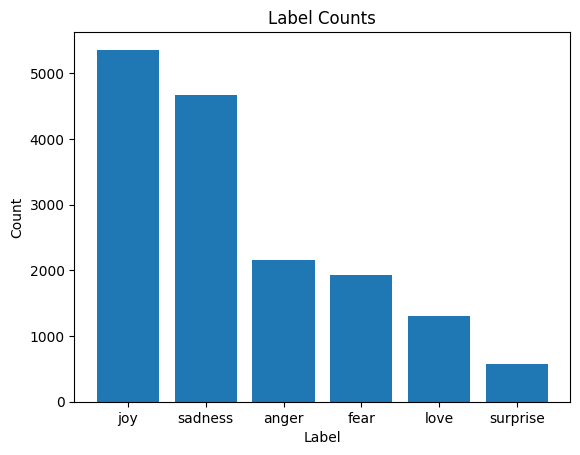

In [15]:
# The dataset is highly imbalanced.
X = df["label_name"].value_counts(sort=True)

plt.bar(X["label_name"], X["count"])
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Counts")
plt.show()

In [16]:
# Length of the tweets
df = df.with_columns(
    pl.col("text").str.len_bytes().alias("char_length"),
    pl.col("text").str.split(" ").list.len().alias("n_words"),
)

df.sample(n=10, seed=123)

text,label,label_name,char_length,n_words
str,i64,str,u32,u32
"""i feel that peaceful feeling leave me and i feel down""",1,"""joy""",53,11
"""i feel a longing for i have no idea what if it was ever even there""",2,"""love""",66,16
"""i honestly feel is almost tragic""",0,"""sadness""",32,6
"""i didnt feel if i was having a shitty day i wouldnt usually come right out and say i was having a shitty day""",0,"""sadness""",108,24
"""i do not give flowers all the time as i feel that makes me a wuss and needy""",0,"""sadness""",75,18
"""ive hijacked a fantasy and i feel foolish""",0,"""sadness""",41,8
"""i really feel rotten and my ear hurts so bad but i still managed to work out days and really push the intensity""",0,"""sadness""",111,23
"""i felt like the boys were disadvantaged missing out on all the exciting entertainments at home for children but now i feel like they have had a precious opportunity to get close and familiar with nature""",1,"""joy""",202,36
"""i feel obama is simply because hillary is so hated by so many""",0,"""sadness""",61,13


In [17]:
df.group_by("label_name").agg(
    avg_char_length=pl.col("char_length").mean().round(2),
    avg_n_words=pl.col("n_words").mean().round(2),
).sort("avg_n_words")

label_name,avg_char_length,avg_n_words
str,f64,f64
"""sadness""",92.55,18.36
"""fear""",96.12,18.84
"""anger""",96.91,19.23
"""joy""",98.55,19.5
"""surprise""",101.68,19.97
"""love""",104.03,20.7


In [18]:
# Reset the format
emotions_dataset.reset_format()

#### From Text To Tokens

- **Character-level Tokenization**:
  - a technique in natural language processing where text is broken down into individual characters.
  - useful for tasks such as character-level language modeling or for working with languages that do not have a fixed vocabulary size or clear word boundaries.
  - however, it can be computationally expensive and may not capture the full meaning of the text.

In [19]:
text: str = "Tokenizing text is a core task of NLP."
tokenized_text: list[str] = list(text)  # character level tokenization

console.print(tokenized_text)

[
    'T',
    'o',
    'k',
    'e',
    'n',
    'i',
    'z',
    'i',
    'n',
    'g',
    ' ',
    't',
    'e',
    'x',
    't',
    ' ',
    'i',
    's',
    ' ',
    'a',
    ' ',
    'c',
    'o',
    'r',
    'e',
    ' ',
    't',
    'a',
    's',
    'k',
    ' ',
    'o',
    'f',
    ' ',
    'N',
    'L',
    'P',
    '.'
]

In [20]:
token2idx: dict[str, int] = {
    token: idx for idx, token in enumerate(sorted(set(tokenized_text)))
}
print(f"{token2idx = }")

input_ids: list[int] = [token2idx[token] for token in tokenized_text]

print(f"{input_ids = }")

token2idx = {' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}
input_ids = [5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


#### Onehot Encoding

In [21]:
import torch
import torch.nn.functional as F


input_ids: torch.Tensor = torch.tensor(input_ids)
onehot_encodings: torch.Tensor = F.one_hot(input_ids, num_classes=len(token2idx))
# Each character has a dimension of 20
onehot_encodings.shape

torch.Size([38, 20])

In [22]:
onehot_encodings[:5]

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

#### Word Level Tokenization
- a type of tokenization splits text into individual words. It's a common approach in NLP that aligns well with how humans typically process language.
- It's a simple and intuitive way to tokenize text, making it a popular choice for many NLP tasks.
- however, it may not capture all nuances of language, such as punctuation, abbreviations, or complex words or out of vocabulary words.

In [23]:
tokenized_text: list[str] = text.split()
print(f"{tokenized_text = }")

tokenized_text = ['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


#### Comment

- Having a large vocabulary in NLP models is problematic due to the enormous number of required parameters.

- Limiting the vocabulary to the most common words (e.g., top 100,000) and mapping rare words to an "unknown" token (UNK) is a common approach to reduce parameters, but this may result in losing important information.

#### Subword-level Tokenization

- it breaks words into smaller units, often combining the benefits of both word-level and character-level approaches.
- handles out-of-vocabulary words better than word-level, captures meaningful subword units.
- however, it's more complex to implement than word-level tokenization and may split words in unintuitive ways.

In [24]:
from transformers import AutoTokenizer, BatchEncoding


model_ckpt: str = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [25]:
encoded_text: BatchEncoding = tokenizer(text)
console.print(f"{encoded_text = }")

encoded_text = {'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 
'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [26]:
encoded_text.input_ids

[101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102]

In [27]:
# It added special tokens at the beginning and the end ([CLS] and [SEP]).
# It also broke some words into subwords.
tokens: list[str] = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
console.print(f"{tokens = }")
console.print(tokenizer.convert_tokens_to_string(tokens))

tokens = ['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']

[CLS] tokenizing text is a core task of nlp. [SEP]

In [28]:
# Commonly used attributes
print(
    f"{tokenizer.vocab_size = }, \n{tokenizer.model_max_length = }, \n{tokenizer.model_input_names = }"
)

tokenizer.vocab_size = 30522, 
tokenizer.model_max_length = 512, 
tokenizer.model_input_names = ['input_ids', 'attention_mask']


<hr>

### Tokenizing The Whole Dataset

- The map() method is used to tokenize the entire corpus. It applies a processing function to each dataset element, creating new rows and columns.
- This method will be frequently used.

In [29]:
def tokenize(batch: Dataset | dict[str, list[str]]) -> dict[str, list[list[str]]]:
    return tokenizer(batch["text"], padding=True, truncation=True)

In [30]:
console.print(train_dataset[:2])
console.print(f"tokenized_data = {tokenize(emotions_dataset['train'][:2])}")

{
    'text': [
        'i didnt feel humiliated',
        'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is 
awake'
    ],
    'label': [0, 0]
}

tokenized_data = {'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 
2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

#### Comment

- The input sequence is padded with zeros to ensure all sequences have the same length. These zeros correspond to a `[PAD]` token in the vocabulary.
- The tokenizer returns attention masks to help the model ignore padded parts of the input, preventing confusion.

<br>

[![image.png](https://i.postimg.cc/bvN60RSs/image.png)](https://postimg.cc/zy6S8Kjr)

- **Fig**: For each batch, the input sequences are padded to the max sequnce length and the attention mask is used in the model to ignore the padded tokens.

In [31]:
# Encode the entire dataset
emotions_dataset_encoded: DatasetDict = emotions_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [32]:
emotions_dataset_encoded.column_names

{'train': ['text', 'label', 'input_ids', 'attention_mask'],
 'validation': ['text', 'label', 'input_ids', 'attention_mask'],
 'test': ['text', 'label', 'input_ids', 'attention_mask']}

<br>

## Training A Classifier

[![image.png](https://i.postimg.cc/NG11MHLV/image.png)](https://postimg.cc/nMhsSM4Y)

- **Fig:** Architecture used for sequence classification with an encoder-based transformer.

- It consists of a pretrained body combined with a custom classification head.

<br>

### Overview

- **Tokenization and Representation**:
  - Text is tokenized and represented as `one-hot vectors` called token encodings.
  - The size of the tokenizer vocabulary determines the dimension of the token encodings.
  - The vocabulary usually consists of 20k–200k unique tokens.

- **Token Embeddings**:
  - Token encodings are converted to token embeddings.
  - Token embeddings are vectors living in a lower-dimensional space.

- **Encoder Block Layers**:
  - Token embeddings are passed through the encoder block layers.
  - This process yields a `hidden state` for each input token.

- **Pretraining Objective (Language Modeling)**:
  - Each hidden state is fed to a layer that predicts the `masked input` tokens.

- **Classification Task**:
  - For classification, the language modeling layer is replaced with a classification layer.

### Two Options of Training A Classifier

#### A.) Feature Extraction

- The hidden states are used as features and fed into a classifier (logistic regression, SVM, etc.) without modifying the pretrained body.

#### B.) Fine-Tuning

- The whole model is trained end-to-end which also updates the pretrained body.

### A.) Transformers As Feature Extractors

In [33]:
from transformers import AutoModel
from transformers.modeling_outputs import BaseModelOutput


model_ckpt: str = "distilbert-base-uncased"
device: str = "cuda" if torch.cuda.is_available() else "cpu"
model: AutoModel = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [34]:
# Extracting the last hidden states
text: str = "this is a test"
inputs = tokenizer(text, return_tensors="pt")

# (batch_size, n_tokens)
print(f"Input tensor shape: {inputs['input_ids'].shape}")

Input tensor shape: torch.Size([1, 6])


In [35]:
# Place the input tensors on the right device
inputs = {k: v.to(device) for k, v in inputs.items()}


# Extract the last hidden states
with torch.no_grad():
    outputs: BaseModelOutput = model(**inputs)

print(f"{outputs = }")

outputs = BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [36]:
# (batch_size, n_tokens, hidden_dim)
outputs.last_hidden_state.shape

torch.Size([1, 6, 768])

#### Comment

- The hidden state tensor contains `768`-dimensional vectors for each input token.
- For classification, the hidden state of the `[CLS]` token is often used as input feature.
- This is because it's designed to capture a `global representation` of the entire input sequence.

In [37]:
# Select all the batches and the first token (CLS token)
outputs.last_hidden_state[:, 0].shape

torch.Size([1, 768])

In [38]:
# Extract all the hidden states
def extract_hidden_states(
    batch: DatasetDict | dict[str, list[str]]
) -> dict[str, list[list[float]]]:
    # Place the input tensors on the right device
    inputs = {
        k: torch.tensor(v).to(device)
        for k, v in batch.items()
        if k in tokenizer.model_input_names
    }

    # Extract the last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        # Return the tensor for the last hidden states
        return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [39]:
emotions_dataset_encoded.column_names

{'train': ['text', 'label', 'input_ids', 'attention_mask'],
 'validation': ['text', 'label', 'input_ids', 'attention_mask'],
 'test': ['text', 'label', 'input_ids', 'attention_mask']}

In [40]:
# Set the format and select the columns
emotions_dataset_encoded.set_format(
    "torch", columns=["input_ids", "attention_mask", "label"]
)

# Extract all the hidden states
emotions_dataset_hidden: DatasetDict = emotions_dataset_encoded.map(
    extract_hidden_states, batched=True
)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [41]:
emotions_dataset_hidden.column_names

{'train': ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
 'validation': ['text',
  'label',
  'input_ids',
  'attention_mask',
  'hidden_state'],
 'test': ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']}

#### Create Feature Matrix

In [42]:
X_train: np.ndarray = np.array(emotions_dataset_hidden["train"]["hidden_state"])
X_valid: np.ndarray = np.array(emotions_dataset_hidden["validation"]["hidden_state"])
X_test: np.ndarray = np.array(emotions_dataset_hidden["test"]["hidden_state"])

y_train: np.ndarray = np.array(emotions_dataset_hidden["train"]["label"])
y_valid: np.ndarray = np.array(emotions_dataset_hidden["validation"]["label"])
y_test: np.ndarray = np.array(emotions_dataset_hidden["test"]["label"])

print(f"{X_train.shape = } | {X_valid.shape = } | {X_test.shape = }")

X_train.shape = (16000, 768) | X_valid.shape = (2000, 768) | X_test.shape = (2000, 768)


#### Train A Simple Classifier

In [43]:
from sklearn.linear_model import LogisticRegression


log_clf: LogisticRegression = LogisticRegression(max_iter=3_000, random_state=123)
log_clf.fit(X_train, y_train)

log_clf.score(X_valid, y_valid)

0.634

In [44]:
# Compare the accuracy with the baseline model
(np.bincount(y_train) / y_train.shape[0]).max()

0.335125

In [45]:
# Compare the accuracy with a baseline model

from sklearn.dummy import DummyClassifier


dummy_clf: DummyClassifier = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

dummy_clf.score(X_valid, y_valid)

0.352

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def plot_confusion_matrix(y_preds, y_true, labels) -> None:

    cm = confusion_matrix(y_true, y_preds, normalize="true")
    _, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.tight_layout()
    plt.show()

In [47]:
labels: list[str] = (
    df.group_by("label_name")
    .agg(label=pl.col("label").map_elements(lambda x: list(set(x))[0]))
    .sort(by="label", descending=False)["label_name"]
    .to_list()
)

labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

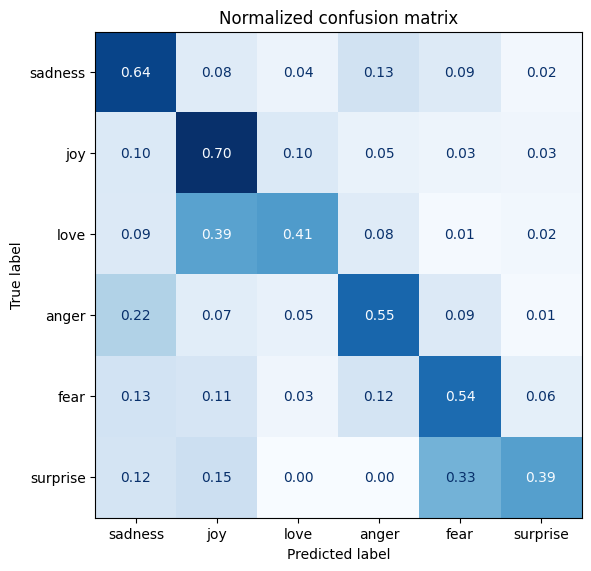

In [48]:
plot_confusion_matrix(y_test, log_clf.predict(X_test), labels=labels)

In [49]:
df["label_name"].unique(maintain_order=True)
df.group_by("label_name").agg(
    label=pl.col("label").map_elements(lambda x: list(set(x))[0])
).sort(by="label", descending=False)["label_name"].to_list()

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

### Fine-Tuning Transformers for Text Classification

<br>

[![image.png](https://i.postimg.cc/dVg4TTcy/image.png)](https://postimg.cc/VJBjxv6f)

<br>

- This requires the classification head to be `differentiable`, which is why this method usually uses a `neural network` for classification.

- By training the hidden states, we can ensure that the model learns to represent the data effectively for the classification task, improving its accuracy.

In [50]:
# Model with classifier head
from transformers import AutoModelForSequenceClassification

num_labels: int = len(emotions_dataset["train"].unique("label"))
model: AutoModelForSequenceClassification = (
    AutoModelForSequenceClassification.from_pretrained(
        pretrained_model_name_or_path=model_ckpt, num_labels=num_labels
    ).to(device)
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
# Define metrics
from sklearn.metrics import accuracy_score, f1_score


def compute_metrics(pred: Dataset) -> dict[str, float]:
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### Training The Model

##### Login

- Using Jupyter notebook

```py
from huggingface_hub import notebook_login

notebook_login()
```

- Using the CLI

```sh
huggingface-cli login
```

In [53]:
from huggingface_hub import notebook_login


notebook_login()

In [54]:
from transformers import Trainer, TrainingArguments
from transformers import Trainer


run_cell: bool = True

if run_cell:
    batch_size: int = 64
    logging_steps: int = len(emotions_dataset_encoded["train"])  # batch_size
    model_name: str = f"{model_ckpt}-finetuned-emotion"
    training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=2,
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        disable_tqdm=False,
        logging_steps=logging_steps,
        push_to_hub=True,
        log_level="error",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=emotions_dataset_encoded["train"],
        eval_dataset=emotions_dataset_encoded["validation"],
        tokenizer=tokenizer,
    )
    trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.297789,0.911500,0.910742
2,No log,0.210385,0.925500,0.925510


In [55]:
if run_cell:
    preds_output = trainer.predict(emotions_dataset_encoded["validation"])
    print(preds_output.metrics)

    y_preds: np.ndarray = np.argmax(preds_output.predictions, axis=1)

{'test_loss': 0.2103845477104187, 'test_accuracy': 0.9255, 'test_f1': 0.9255099773116874, 'test_runtime': 3.7674, 'test_samples_per_second': 530.874, 'test_steps_per_second': 8.494}


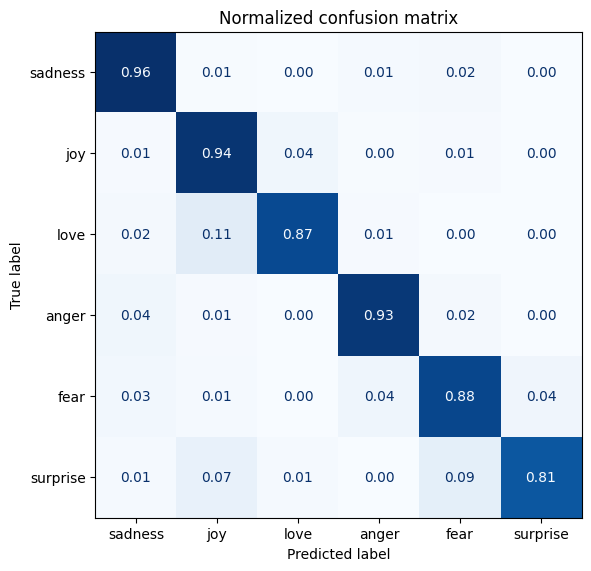

In [56]:
if run_cell:
    plot_confusion_matrix(y_preds, y_valid, labels)

### Error Analysis

- Let's analyze our model's predictions by sorting validation samples by their loss.
- We can calculate the loss and predicted label during the forward pass.

In [88]:
import torch.nn.functional as F


def forward_pass_with_label(
    batch: dict[str, Any]
) -> dict[str, Union[np.ndarray, torch.Tensor]]:
    """
    Perform a forward pass through the model and calculate the loss.

    Parameters
    ----------
    batch : dict[str, Any]
        A dictionary containing the input batch data.

    Returns
    -------
    dict[str, Union[np.ndarray, torch.Tensor]]
        A dictionary containing the loss and predicted labels.
        - 'loss': np.ndarray of shape (batch_size,)
        - 'predicted_label': torch.Tensor of shape (batch_size,)
    """
    inputs: dict[str, torch.Tensor] = {}
    for k, v in batch.items():
        if k in tokenizer.model_input_names:
            if isinstance(v, list):
                if isinstance(v[0], torch.Tensor):
                    # Find the maximum length in the batch
                    max_len: int = max([t.size(0) for t in v])
                    # Pad all tensors to the maximum length
                    v = [F.pad(t, (0, max_len - t.size(0))) for t in v]
                    # Stack the padded tensors
                    v = torch.stack(v)
                else:
                    v = torch.tensor(v)
            inputs[k] = v.to(device)

    with torch.no_grad():
        output = model(**inputs)
        pred_label: torch.Tensor = torch.argmax(output.logits, axis=-1)
        loss: torch.Tensor = F.cross_entropy(
            output.logits, batch["label"].to(device), reduction="none"
        )

    return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}


In [86]:
emotions_dataset_encoded.set_format(
    "torch", columns=["input_ids", "attention_mask", "label"]
)
# Compute loss values
emotions_dataset_encoded["validation"] = emotions_dataset_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [87]:
emotions_dataset_encoded.set_format("polars")

cols: list[str] = ["text", "label", "predicted_label", "loss"]
df_test: pl.DataFrame = emotions_dataset_encoded["validation"][:][cols]
df_test = df_test.with_columns(
    label=pl.col("label").map_elements(
        lambda x: emotions_dataset["train"].features["label"].int2str(x)
    ),
    predicted_label=pl.col("predicted_label").map_elements(
        lambda x: emotions_dataset["train"].features["label"].int2str(x)
    ),
)

df_test.head()

text,label,predicted_label,loss
str,str,str,f32
"""im feeling quite sad and sorry for myself but ill snap out of it soon""","""sadness""","""sadness""",0.020188
"""i feel like i am still looking at a blank canvas blank pieces of paper""","""sadness""","""sadness""",0.020689
"""i feel like a faithful servant""","""love""","""love""",0.388864
"""i am just feeling cranky and blue""","""anger""","""anger""",0.029396
"""i can have for a treat or if i am feeling festive""","""joy""","""joy""",0.018554


In [89]:
df_test.sort("loss", descending=True).head(10)

text,label,predicted_label,loss
str,str,str,f32
"""i called myself pro life and voted for perry without knowing this information i would feel betrayed but moreover i would feel that i had betrayed god by supporting a man who mandated a barely year old vaccine for little girls putting them in danger to financially support people close to him""","""joy""","""sadness""",5.731069
"""i guess we would naturally feel a sense of loneliness even the people who said unkind things to you might be missed""","""anger""","""sadness""",5.40083
"""i guess i feel betrayed because i admired him so much and for someone to do this to his wife and kids just goes beyond the pale""","""joy""","""sadness""",5.392826
"""i as representative of everything thats wrong with corporate america and feel that sending him to washington is a ludicrous idea""","""surprise""","""sadness""",5.28798
"""i feel badly about reneging on my commitment to bring donuts to the faithful at holy family catholic church in columbus ohio""","""love""","""sadness""",5.088324
"""i felt ashamed of these feelings and was scared because i knew that something wrong with me and thought i might be gay""","""fear""","""sadness""",4.947172
"""i am going to several holiday parties and i can t wait to feel super awkward i am going to several holiday parties and i can t wait to feel super awkward a href http badplaydate""","""joy""","""sadness""",4.870105
"""im lazy my characters fall into categories of smug and or blas people and their foils people who feel inconvenienced by smug and or blas people""","""joy""","""fear""",4.796072
"""i feel vaguely cheated and a little amused""","""joy""","""anger""",4.272856


#### Comment

- The model made errors and encountered ambiguous cases.

- `Joy` was frequently mislabeled. Refining the dataset can significantly improve performance.

- When analyzing the lowest loss samples, we notice the model is most confident about predicting sadness.

- However, deep learning models can find shortcuts, so it's important to examine the model's most confident predictions to ensure it's not exploiting specific text features.

- Let's analyze the lowest loss predictions.

In [90]:
df_test.sort("loss", descending=False).head(10)

text,label,predicted_label,loss
str,str,str,f32
"""im feeling very jaded and uncertain about love and all basically im sick of being the one more in love of falling for someone who doesnt feel as much towards me""","""sadness""","""sadness""",0.015938
"""i always feel guilty and come to one conclusion that stops me emily would be so disappointed in me""","""sadness""","""sadness""",0.016091
"""i forgive stanley hes not so quick to forgive as well and accuses me of making a foolish mistake and making him feel unwelcome in our apt""","""sadness""","""sadness""",0.016115
"""im tired of feeling lethargic hating to work out and being broke all the time""","""sadness""","""sadness""",0.016154
"""i feel like im an unwelcome presence whenever she is around""","""sadness""","""sadness""",0.016229
"""im kinda relieve but at the same time i feel disheartened""","""sadness""","""sadness""",0.016354
"""i suppose it all goes along with feeling unwelcome and mostly being shunned""","""sadness""","""sadness""",0.016358
"""im starting to feel unwelcome in there""","""sadness""","""sadness""",0.016361
"""i feel unwelcome in this town as if my time here has been spent my quota of memories well past brimming and my eviction notice is long overdue""","""sadness""","""sadness""",0.016388


In [ ]:
# # Save the model
# trainer.push_to_hub(commit_message="Training completed!")

In [ ]:
# from transformers import pipeline


# model_id: str = "your-model-id"
# classifier = pipeline("text-classification", model=model_id)

In [ ]:
# custom_tweet: str = "I saw a movie today and it was really good."
# preds = classifier(custom_tweet, return_all_scores=True)
